# Clustering of human-readable multi-feature data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
#import matplotlib.patches as patches
from sklearn.cluster import KMeans
#from sklearn import metrics
from matplotlib import cm
from sklearn.preprocessing import MinMaxScaler
from matplotlib.lines import Line2D

In [2]:
# read in data 
pathData_train = 'data/training_extracted_features_and_labels.h5'
db_train = pd.read_hdf(pathData_train, 'df')

In [3]:
pceLims=(5,17.5)
vocLims=(0.9,1.15)
jscLims=(16,22)
ffLims=(40,75)
fontSizeSetLarge=18
fontSizeSetMedium=14

# Figure 3

## one feature as model input

In [4]:
# get data of single feature
label="pce_mean"
feature_1="insitu_feature_1"
data = pd.DataFrame(db_train[feature_1])
X = data.values.copy()
sc = MinMaxScaler()
X = sc.fit_transform(X.reshape(-1,1))

In [5]:
# generate a kmeans model with k = 4
k = 4
km = KMeans(n_clusters = k, random_state = 0)
cluster_found = km.fit_predict(X)
clusteringOne = data.set_index(pd.Series(cluster_found, name = 'cluster'), append = True )
cluster_values = sorted(clusteringOne.index.get_level_values('cluster').unique())

In [6]:
# generate 4 colors from the colormap viridis
ks=np.linspace(0.3,0.9,k)
color_list = []
cmap = plt.cm.get_cmap('viridis')
for zz in range(len(ks)):
    color_list.append(cmap(ks[zz]))

In [7]:
# generate a nested list with the PV parameters (pce,voc,jsc,ff) and layer thickness for the 4 generated clusters
listPCE,listVOC,listJSC,listFF,listThickness = [],[],[],[],[]
for cluster, color in zip(cluster_values, color_list):
    clusterDF = clusteringOne.xs(cluster, level = 1)
    listPCE.append(db_train.iloc[clusterDF.index]["pce_mean"])
    listVOC.append(db_train.iloc[clusterDF.index]["voc_mean"])
    listJSC.append(db_train.iloc[clusterDF.index]["jsc_mean"])
    listFF.append(db_train.iloc[clusterDF.index]["ff_mean"])
    listThickness.append(db_train.iloc[clusterDF.index]["meanThickness"])
pvParamsClusters_unsorted = [listPCE,listVOC,listJSC,listFF,listThickness]

In [8]:
# sort the nested list. the order of the clusters is changed so that the mean pce of the cluster increases with cluster number
meanList = []
for x in range(len(listPCE)):
    meanList.append(np.mean(listPCE[x]))
sortBy = sorted(range(len(meanList)), key = lambda k: meanList[k])
newClusters = []
for a in range(len(sortBy)):
    newClusters.append(sortBy.index(a))
cluster_found_sorted = pd.Series(np.array(newClusters)[np.array(clusteringOne.index.get_level_values('cluster'))], name='cluster')
clusteringOne = data.set_index(cluster_found_sorted, append = True )
clusters = sorted(clusteringOne.index.get_level_values('cluster').unique())
listPCE_sorted = np.array(listPCE,dtype = object)[sortBy]
listVOC_sorted = np.array(listVOC,dtype = object)[sortBy]
listJSC_sorted = np.array(listJSC,dtype = object)[sortBy]
listFF_sorted = np.array(listFF,dtype = object)[sortBy]
listThickness_sorted = np.array(listThickness,dtype = object)[sortBy]
pvParamsClusters = [listPCE_sorted,listVOC_sorted,listJSC_sorted,listFF_sorted,listThickness_sorted]

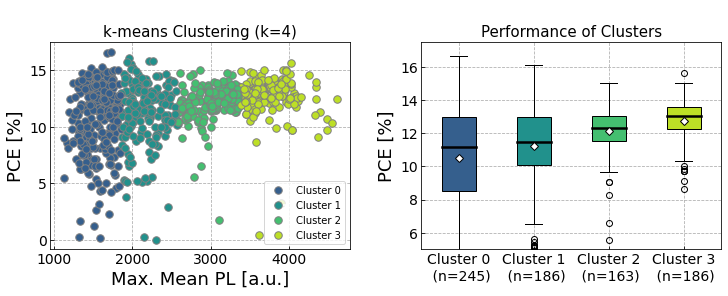

In [9]:
# plotting the results
fig,ax = plt.subplots(1,2, figsize=(10,4), constrained_layout=True)

# plotting the boxplots
medianprops = dict(linestyle='-', linewidth=2.5, color='k')
meanprops = dict(marker='D', markeredgecolor='black',markerfacecolor='white')
bplot1=ax[1].boxplot(pvParamsClusters[0], medianprops=medianprops, meanprops=meanprops, meanline=False, showmeans=True, patch_artist=True) 
cnt=0
for box in bplot1['boxes']:
    box.set(facecolor = color_list[cnt] ) 
    cnt+=1   
ax[1].set_xticks(np.add(clusters,1), minor=False)
nList=[]
for cluster, color in zip(clusters, color_list):  
    clusterDF=clusteringOne.xs(cluster, level=1)
    nList.append("\n (n=" +str(len(clusterDF))+")")
xlabels=[]
for x in range(len(clusters)):
    xlabels.append("Cluster " + str(clusters[x]))      
newList=[]
for yy in range(len(xlabels)):
    newList.append(xlabels[yy]+nList[yy])
ax[1].set_xticklabels(newList, fontdict=None, minor=False,fontsize=fontSizeSetMedium)
ax[1].set_ylabel("\nPCE [%]",fontsize=fontSizeSetLarge)  


# plotting the scatter plots
for x in range(len(clusteringOne)):
    clusterNo=clusteringOne.index.get_level_values("cluster")[x]
    labelValue=db_train.loc[data.index[x],label]
    featureValue1=clusteringOne.loc[clusteringOne.index[x],feature_1]
    #featureValue2=clusteringOne.loc[clusteringOne.index[x],feature_1]
    ax[0].plot(featureValue1,labelValue,".",color=color_list[clusterNo],ms = 15, mec="gray")

patchList=[]
for xx in range(len(clusters)):
    patchList.append(Line2D([0], [0], marker='.', color='w', label=xlabels[xx], markerfacecolor=color_list[xx], markersize=15,mec='gray'))
ax[0].legend(handles=patchList,fontsize=10)   
ax[0].set_ylabel("PCE [%]",fontsize=fontSizeSetLarge)
ax[0].set_xlabel("Max. Mean PL [a.u.]",fontsize=fontSizeSetLarge)
ax[0].set_title("\nk-means Clustering (k="+ str(k)+")", fontsize=15)   
ax[1].set_title("\nPerformance of Clusters", fontsize=15)   
ax[1].set_ylim(pceLims)
ax[0].grid(which="both", linestyle='--')
ax[1].grid(which="both", linestyle='--')
ax[0].tick_params(axis='both', which='major',direction="in", labelsize=fontSizeSetMedium)
ax[1].tick_params(axis='both', which='major',direction="in", labelsize=fontSizeSetMedium)       
plt.show()   

## two features as model input

In [10]:
# get data acquired 
label="pce_mean"
feature_1="insitu_feature_1"
feature_2="insitu_feature_2"
data = pd.DataFrame(db_train[[feature_2,feature_1]])
X = data.values.copy()
sc = MinMaxScaler()
X = sc.fit_transform(X)

In [11]:
# generate a kmeans model with k = 4
k = 4
km = KMeans(n_clusters = k, random_state = 0)
cluster_found = km.fit_predict(X)
clusteringTwo = data.set_index(pd.Series(cluster_found, name = 'cluster'), append = True )
cluster_values = sorted(clusteringTwo.index.get_level_values('cluster').unique())

In [12]:
# generate 4 colors from the colormap cool
ks=np.linspace(0.1,0.99,k)
color_list = []
cmap = plt.cm.get_cmap('cool')
for zz in range(len(ks)):
    color_list.append(cmap(ks[zz]))

In [13]:
# generate a nested list with the PV parameters (pce,voc,jsc,ff) and layer thickness for the 4 generated clusters
listPCE,listVOC,listJSC,listFF,listThickness = [],[],[],[],[]
for cluster, color in zip(cluster_values, color_list):
    clusterDF = clusteringTwo.xs(cluster, level = 1)
    listPCE.append(db_train.iloc[clusterDF.index]["pce_mean"])
    listVOC.append(db_train.iloc[clusterDF.index]["voc_mean"])
    listJSC.append(db_train.iloc[clusterDF.index]["jsc_mean"])
    listFF.append(db_train.iloc[clusterDF.index]["ff_mean"])
    listThickness.append(db_train.iloc[clusterDF.index]["meanThickness"])
pvParamsClusters_unsorted = [listPCE,listVOC,listJSC,listFF,listThickness]

In [14]:
# sort the nested list. the order of the clusters is changed so that the mean pce of the cluster increases with cluster number
meanList = []
for x in range(len(listPCE)):
    meanList.append(np.mean(listPCE[x]))
sortBy = sorted(range(len(meanList)), key = lambda k: meanList[k])
newClusters = []
for a in range(len(sortBy)):
    newClusters.append(sortBy.index(a))
cluster_found_sorted = pd.Series(np.array(newClusters)[np.array(clusteringTwo.index.get_level_values('cluster'))], name='cluster')
clusteringTwo = data.set_index(cluster_found_sorted, append = True )
clusters = sorted(clusteringTwo.index.get_level_values('cluster').unique())
listPCE_sorted = np.array(listPCE,dtype = object)[sortBy]
listVOC_sorted = np.array(listVOC,dtype = object)[sortBy]
listJSC_sorted = np.array(listJSC,dtype = object)[sortBy]
listFF_sorted = np.array(listFF,dtype = object)[sortBy]
listThickness_sorted = np.array(listThickness,dtype = object)[sortBy]
pvParamsClusters = [listPCE_sorted,listVOC_sorted,listJSC_sorted,listFF_sorted,listThickness_sorted]

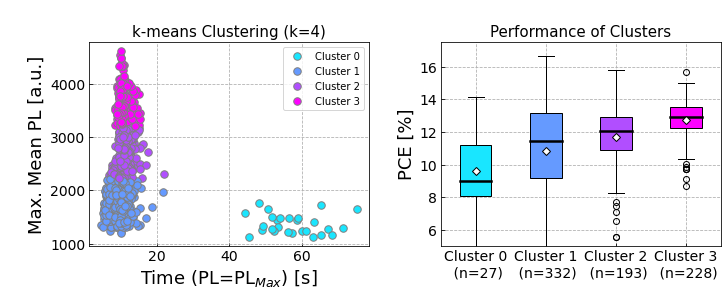

In [15]:
# plotting the results
fig,ax = plt.subplots(1,2, figsize=(10,4), constrained_layout=True)

# plotting the boxplots
medianprops = dict(linestyle='-', linewidth=2.5, color='k')
meanprops = dict(marker='D', markeredgecolor='black',markerfacecolor='white')
bplot1=ax[1].boxplot(pvParamsClusters[0], medianprops=medianprops, meanprops=meanprops, meanline=False, showmeans=True, patch_artist=True) 
cnt=0
for box in bplot1['boxes']:
    box.set(facecolor = color_list[cnt] ) 
    cnt+=1   
ax[1].set_xticks(np.add(clusters,1), minor=False)

nList=[]
for cluster, color in zip(clusters, color_list):  
    clusterDF=clusteringTwo.xs(cluster, level=1)
    nList.append("\n (n=" +str(len(clusterDF))+")")
xlabels=[]
for x in range(len(clusters)):
    xlabels.append("Cluster " + str(clusters[x]))      # no rearrange cluster number
newList=[]
for yy in range(len(xlabels)):
    newList.append(xlabels[yy]+nList[yy])
ax[1].set_xticklabels(newList, fontdict=None, minor=False,fontsize=fontSizeSetMedium)
ax[1].set_ylabel("\nPCE [%]",fontsize=fontSizeSetLarge)  


# plotting the scatter plots
for x in range(len(clusteringTwo)):
    clusterNo=clusteringTwo.index.get_level_values("cluster")[x]
    featureValue1=clusteringTwo.loc[clusteringTwo.index[x],feature_2]
    featureValue2=clusteringTwo.loc[clusteringTwo.index[x],feature_1]
    ax[0].plot(featureValue1,featureValue2,".",color=color_list[clusterNo],ms = 15, mec="gray")
patchList=[]
for xx in range(len(clusters)):
    patchList.append(Line2D([0], [0], marker='.', color='w', label=xlabels[xx], markerfacecolor=color_list[xx], markersize=15,mec='gray'))
ax[0].legend(handles=patchList,fontsize=10)   
ax[0].set_xlabel("Time (PL=PL$_{Max}$) [s]",fontsize=fontSizeSetLarge)
ax[0].set_ylabel("\nMax. Mean PL [a.u.]",fontsize=fontSizeSetLarge)
ax[0].set_title("\nk-means Clustering (k="+ str(k)+")", fontsize=15)   
ax[1].set_title("\nPerformance of Clusters", fontsize=15)   
ax[1].set_ylim(pceLims)
ax[0].grid(which="both", linestyle='--')
ax[1].grid(which="both", linestyle='--')
ax[0].tick_params(axis='both', which='major',direction="in", labelsize=fontSizeSetMedium)
ax[1].tick_params(axis='both', which='major',direction="in", labelsize=fontSizeSetMedium)       
plt.show()   

## three features as model input

In [16]:
# get data acquired 
label="pce_mean"
subset=["insitu_feature_2", "insitu_feature_1", "insitu_feature_3"]
data = pd.DataFrame(db_train[subset])
X = data.values.copy()
sc = MinMaxScaler()
X = sc.fit_transform(X)

In [17]:
# generate a kmeans model with k = 4
k = 4
km = KMeans(n_clusters = k, random_state = 0)
cluster_found = km.fit_predict(X)
clusteringThree = data.set_index(pd.Series(cluster_found, name = 'cluster'), append = True )
cluster_values = sorted(clusteringThree.index.get_level_values('cluster').unique())

In [18]:
# generate 4 colors from the colormap plasma
ks=np.linspace(0.3,0.95,k)
color_list = []
cmap = plt.cm.get_cmap('plasma')
for zz in range(len(ks)):
    color_list.append(cmap(ks[zz]))

In [19]:
# generate a nested list with the PV parameters (pce,voc,jsc,ff) and layer thickness for the 4 generated clusters
listPCE,listVOC,listJSC,listFF,listThickness = [],[],[],[],[]
for cluster, color in zip(cluster_values, color_list):
    clusterDF = clusteringThree.xs(cluster, level = 1)
    listPCE.append(db_train.iloc[clusterDF.index]["pce_mean"])
    listVOC.append(db_train.iloc[clusterDF.index]["voc_mean"])
    listJSC.append(db_train.iloc[clusterDF.index]["jsc_mean"])
    listFF.append(db_train.iloc[clusterDF.index]["ff_mean"])
    listThickness.append(db_train.iloc[clusterDF.index]["meanThickness"])
pvParamsClusters_unsorted = [listPCE,listVOC,listJSC,listFF,listThickness]

In [20]:
# sort the nested list. the order of the clusters is changed so that the mean pce of the cluster increases with cluster number
meanList = []
for x in range(len(listPCE)):
    meanList.append(np.mean(listPCE[x]))
sortBy = sorted(range(len(meanList)), key = lambda k: meanList[k])
newClusters = []
for a in range(len(sortBy)):
    newClusters.append(sortBy.index(a))
cluster_found_sorted = pd.Series(np.array(newClusters)[np.array(clusteringThree.index.get_level_values('cluster'))], name='cluster')
clusteringThree = data.set_index(cluster_found_sorted, append = True )
clusters = sorted(clusteringThree.index.get_level_values('cluster').unique())
listPCE_sorted = np.array(listPCE,dtype = object)[sortBy]
listVOC_sorted = np.array(listVOC,dtype = object)[sortBy]
listJSC_sorted = np.array(listJSC,dtype = object)[sortBy]
listFF_sorted = np.array(listFF,dtype = object)[sortBy]
listThickness_sorted = np.array(listThickness,dtype = object)[sortBy]
pvParamsClusters = [listPCE_sorted,listVOC_sorted,listJSC_sorted,listFF_sorted,listThickness_sorted]

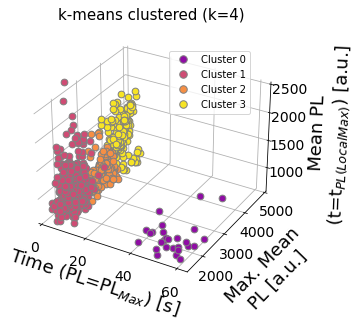

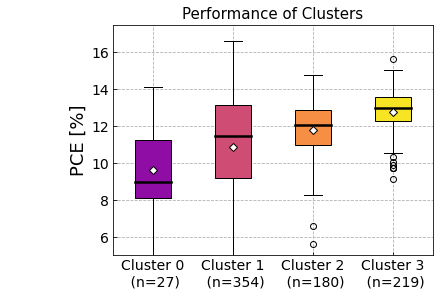

In [21]:
# plotting the results
fig1 = plt.figure(figsize=(6,4), constrained_layout=True)
fig2 = plt.figure(figsize=(6,4), constrained_layout=True)
ax1 = fig1.add_subplot(111, projection='3d')
ax2 = fig2.add_subplot(111)

# plotting the boxplots
medianprops = dict(linestyle='-', linewidth=2.5, color='k')
meanprops = dict(marker='D', markeredgecolor='black',markerfacecolor='white')
bplot1=ax2.boxplot(pvParamsClusters[0], medianprops=medianprops,meanprops=meanprops, meanline=False, showmeans=True, patch_artist=True) 
cnt=0
for box in bplot1['boxes']:
    box.set(facecolor = color_list[cnt] ) 
    cnt+=1   
ax2.set_xticks(np.add(clusters,1), minor=False)
nList=[]
for cluster, color in zip(clusters, color_list):  
    clusterDF=clusteringThree.xs(cluster, level=1)
    nList.append("\n (n=" +str(len(clusterDF))+")")  
xlabels=[]
for x in range(len(clusters)):
    xlabels.append("Cluster " + str(clusters[x]))      # no rearrange cluster number    
newList=[]
for yy in range(len(xlabels)):
    newList.append(xlabels[yy]+nList[yy])
ax2.set_xticklabels(newList, fontdict=None, minor=False,fontsize=fontSizeSetMedium)
ax2.set_ylabel("\n\n\nPCE [%]",fontsize=fontSizeSetLarge)  
ax2.set_ylim(pceLims)
ax2.grid(which="both", linestyle='--')


# plotting the scatter plots
feature_1=subset[0]
feature_2=subset[1]
feature_3=subset[2]
for x in range(len(clusteringThree)):
    clusterNo=clusteringThree.index.get_level_values("cluster")[x]
    featureValue1=clusteringThree.loc[clusteringThree.index[x],feature_1]
    featureValue2=clusteringThree.loc[clusteringThree.index[x],feature_2]
    featureValue3=clusteringThree.loc[clusteringThree.index[x],feature_3]
    ax1.scatter3D(featureValue1,featureValue2,featureValue3,".",color=color_list[clusterNo], alpha=1,s = 45,edgecolors="gray");
patchList=[]
for xx in range(len(clusters)):
    patchList.append(Line2D([0], [0], marker='.', color='w', label=xlabels[xx], markerfacecolor=color_list[xx], markersize=15,mec='gray'))
ax1.legend(handles=patchList, bbox_to_anchor=(0.55, 0.92)) # (x,y)
ax1.set_xlabel("Time (PL=PL$_{Max}$) [s]",fontsize=fontSizeSetLarge)
ax1.set_ylabel("\n\nMax. Mean\nPL [a.u.]",fontsize=fontSizeSetLarge)  
ax1.set_zlabel("\n\nMean PL\n(t=t$_{PL(Local Max)}$) [a.u.]",fontsize=fontSizeSetLarge)  
ax1.set_xlim(0,63)
ax1.set_ylim(1400,5000)
ax1.set_zlim(600,2500)
ax1.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax1.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax1.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax1.set_title("k-means clustered (k="+ str(k)+")", fontsize=15)  
ax2.set_title("Performance of Clusters", fontsize=15)   
ax1.tick_params(axis='both', which='major',direction="in", labelsize=fontSizeSetMedium)
ax2.tick_params(axis='both', which='major',direction="in", labelsize=fontSizeSetMedium)
plt.show()      